## 1-1번 검증

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from scipy.stats import ttest_ind, mannwhitneyu
import seaborn as sns

# 그래프 한글 폰트 설정 (선택 사항)
plt.rcParams['font.family'] = 'DejaVu Sans'  # 또는 'NanumGothic'

In [4]:
import os
import json
import pandas as pd
from tqdm import tqdm
import random

def load_sampled_articles(base_dirs, total_samples=300000):
    all_json_files = []

    # 1. 모든 JSON 파일 경로 수집
    for base_dir in base_dirs:
        for root, _, files in os.walk(base_dir):
            for file in files:
                if file.endswith(".json"):
                    all_json_files.append(os.path.join(root, file))

    # 2. 랜덤 샘플링
    random.seed(42)
    sampled_paths = random.sample(all_json_files, total_samples)

    # 3. 샘플 파일 파싱
    records = []
    for path in tqdm(sampled_paths):
        try:
            with open(path, 'r', encoding='utf-8') as f:
                j = json.load(f)
                content = j.get("sourceDataInfo", {}).get("newsContent", "").strip()
                process_type = j.get("sourceDataInfo", {}).get("processType", "")

                if content and process_type in ['A', 'D']:
                    records.append({
                        "content": content,
                        "processType": process_type
                    })
        except Exception as e:
            print(f"[ERROR] {path}: {e}")

    df = pd.DataFrame(records)
    df["label"] = df["processType"].map({"A": "자동 생성형", "D": "직접 작성형"})
    return df


In [5]:
train_dir = "/home/linux1126/146.낚시성 기사 탐지 데이터/01-1.정식개방데이터/Training"
val_dir = "/home/linux1126/146.낚시성 기사 탐지 데이터/01-1.정식개방데이터/Validation"

df = load_sampled_articles([train_dir, val_dir], total_samples=300000)
print(df['label'].value_counts())
df.head()


100%|██████████| 300000/300000 [00:17<00:00, 16958.79it/s]


label
자동 생성형    259083
직접 작성형     40917
Name: count, dtype: int64


,content,processType,label
0,대만의 유명 룸살롱 종업원이 신종 코로나바이러스 감염증(코로나19) 확진 판정을 받...,A,자동 생성형
1,박찬욱의 를 칸영화제에서 먼저 본 비평가들이 가장 많이 던지는 표현은 ‘메일 게이즈...,A,자동 생성형
2,홈플러스는 최근 코로나19 재확산세가 심화되면서 모바일 매출이 크게 늘었다고 21일...,A,자동 생성형
3,국가정보원에서 특수활동비 총 36억5000만원을 박근혜 전 대통령(66)에게 상납하...,A,자동 생성형
4,"윤석열 전 검찰총장은 4일 최근 당원수가 급격히 증가한 것과 관련해 \""위장당원이 ...",A,자동 생성형


In [6]:
# 직접 작성형 수만큼 자동 생성형을 무작위 샘플링
n = df[df['label'] == '직접 작성형'].shape[0]

df_auto = df[df['label'] == '자동 생성형'].sample(n=n, random_state=42)
df_direct = df[df['label'] == '직접 작성형']

# 병합 (클래스 균형 맞춤)
df_balanced = pd.concat([df_auto, df_direct]).reset_index(drop=True)

print(df_balanced['label'].value_counts())


label
자동 생성형    40917
직접 작성형    40917
Name: count, dtype: int64


In [5]:
# 전체 데이터 추출

import os
import json
from tqdm import tqdm

def count_direct_articles(base_dirs):
    count = 0
    total = 0

    for base_dir in base_dirs:
        for root, _, files in os.walk(base_dir):
            for file in files:
                if file.endswith(".json"):
                    total += 1
                    try:
                        with open(os.path.join(root, file), 'r', encoding='utf-8') as f:
                            j = json.load(f)
                            process_type = j.get("sourceDataInfo", {}).get("processType", "")
                            if process_type == "D":
                                count += 1
                    except Exception as e:
                        print(f"[ERROR] {file}: {e}")
    
    print(f"전체 기사 수: {total:,}")
    print(f"직접 생성형(D) 기사 수: {count:,}")
    return count


In [6]:
# 파일 경로 설정

train_dir = "/home/linux1126/146.낚시성 기사 탐지 데이터/01-1.정식개방데이터/Training"
val_dir = "/home/linux1126/146.낚시성 기사 탐지 데이터/01-1.정식개방데이터/Validation"

count_direct_articles([train_dir, val_dir])


KeyboardInterrupt: 

In [ ]:
import os
import json
import pandas as pd

def load_balanced_articles(base_dirs, sample_per_class=5000):
    a_samples, d_samples = [], []

    for base_dir in base_dirs:
        for root, _, files in os.walk(base_dir):
            for file in files:
                if file.endswith(".json"):
                    try:
                        with open(os.path.join(root, file), 'r', encoding='utf-8') as f:
                            j = json.load(f)
                            content = j.get("sourceDataInfo", {}).get("newsContent", "").strip()
                            title = j.get("labeledDataInfo", {}).get("newTitle", "").strip()
                            process_type = j.get("sourceDataInfo", {}).get("processType", "")

                            if content and title and process_type == "A" and len(a_samples) < sample_per_class:
                                a_samples.append({
                                    "title": title,
                                    "content": content,
                                    "processType": "A"
                                })
                            elif content and title and process_type == "D" and len(d_samples) < sample_per_class:
                                d_samples.append({
                                    "title": title,
                                    "content": content,
                                    "processType": "D"
                                })

                            if len(a_samples) >= sample_per_class and len(d_samples) >= sample_per_class:
                                break
                    except Exception as e:
                        print(f"[ERROR] {file}: {e}")
        if len(a_samples) >= sample_per_class and len(d_samples) >= sample_per_class:
            break

    df = pd.DataFrame(a_samples + d_samples)
    df["label"] = df["processType"].map({"A": "자동 생성형", "D": "직접 작성형"})
    return df


In [24]:
# 파일 경로 설정
train_dir = "/home/linux1126/146.낚시성 기사 탐지 데이터/01-1.정식개방데이터/Training"
val_dir = "/home/linux1126/146.낚시성 기사 탐지 데이터/01-1.정식개방데이터/Validation"

df = load_balanced_articles([train_dir, val_dir], sample_per_class=5000)
print(df['label'].value_counts())


label
자동 생성형    5000
직접 작성형    5000
Name: count, dtype: int64


In [26]:

df['processPattern'].value_counts()

KeyError: 'processPattern'

In [2]:
# 기본 설정 및 함수 정의

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from scipy.stats import ttest_ind, mannwhitneyu
import seaborn as sns

# 그래프 스타일 설정
sns.set(style="whitegrid")
plt.rcParams['font.family'] = 'DejaVu Sans'

# 다양성 계산 함수
def calc_ngram_diversity(texts, n=2):
    vectorizer = CountVectorizer(ngram_range=(n, n))
    X = vectorizer.fit_transform(texts)
    total = X.sum(axis=1).A1 + 1e-10  # 전체 n-gram 개수
    unique = (X > 0).sum(axis=1).A1   # 고유한 n-gram 수
    return unique / total


In [ ]:
# 데이터 로드
# 이전에 샘플링한 결과 사용
# df_balanced: 10만개 (자동 5만, 직접 5만)
print(df_balanced['label'].value_counts())
df_balanced[['content', 'label']].sample(3)

label
자동 생성형    150000
직접 작성형    150000
Name: count, dtype: int64


,content,label
182978,대전 동구 구성지구 스마트뷰의 원주민 계약마감결과(신청자 292세대·계약자 282세...,직접 작성형
160135,"\""소설 '우리들의 일그러진 영웅'에 나오는 엄석대 같다\"". 21대 국회 첫 국정...",직접 작성형
32242,'거짓 암 투병 의혹' 논란의 중심에 선 가수 최성봉이 의혹을 강하게 반박하며 공개...,자동 생성형


In [33]:
# 다양성 점수 계산
auto_texts = df_balanced[df_balanced['label'] == '자동 생성형']['content']
direct_texts = df_balanced[df_balanced['label'] == '직접 작성형']['content']

# Distinct 2-gram 다양성 지표
# auto_div = calc_ngram_diversity(auto_texts)
# direct_div = calc_ngram_diversity(direct_texts)
auto_texts.head()

0    미얀마 군부의 유혈 진압이 최악으로 치닫자 민주 진영에서 결국 내전(civil wa...
1    태백시는 관내 1000수 이상 산란계 사육농가를 대상으로 난좌 구입비를 지원한다 고...
2    애플에 임신한 남성 이모티콘(그림말)이 추가될 예정이라는 소식이 전해지자 누리꾼들의...
3    5월 출범하는 윤석열 정부가 지방 거점 대학을 고리로 지역 불균형 발전의 해법을 찾...
4    중국이 아프가니스탄 탈레반 정부가 임명한 외교관의 자국 내 파견을 승인했다고 탈레반...
Name: content, dtype: object

In [15]:
# 통계 검정
# 평균 출력
print(f"자동 생성형 평균 다양성: {auto_div.mean():.4f}")
print(f"직접 작성형 평균 다양성: {direct_div.mean():.4f}")

# t-test
t_stat, p_val = ttest_ind(auto_div, direct_div, equal_var=False)
print(f"T-test: t={t_stat:.3f}, p-value={p_val:.4f}")

# Mann–Whitney U test (정규성 무관)
u_stat, p_val_u = mannwhitneyu(auto_div, direct_div, alternative='two-sided')
print(f"Mann–Whitney U test: U={u_stat}, p-value={p_val_u:.4f}")


자동 생성형 평균 다양성: 0.9746
직접 작성형 평균 다양성: 0.9753
T-test: t=-8.144, p-value=0.0000
Mann–Whitney U test: U=11050636610.5, p-value=0.0000


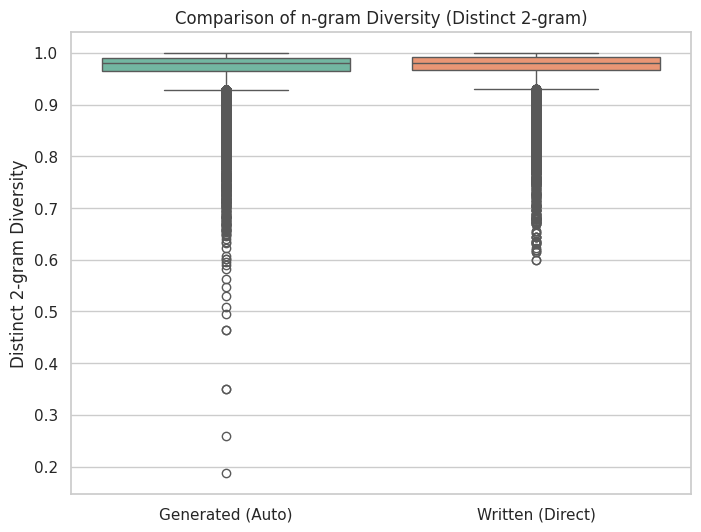

In [16]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=[auto_div, direct_div], palette="Set2")
plt.xticks([0, 1], ['Generated (Auto)', 'Written (Direct)'])
plt.ylabel("Distinct 2-gram Diversity")
plt.title("Comparison of n-gram Diversity (Distinct 2-gram)")
plt.show()


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# 1. 다양성 지표 추출
df['diversity'] = calc_ngram_diversity(df['content'], n=2)
X = df[['diversity']]
y = df['processType']  # 'A' or 'D'

# 2. 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. 분류 모델 학습
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)

# 4. 성능 평가
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=["자동 생성형", "직접 작성형"]))


              precision    recall  f1-score   support

      자동 생성형       0.53      0.47      0.49     29907
      직접 작성형       0.52      0.58      0.55     30093

    accuracy                           0.52     60000
   macro avg       0.52      0.52      0.52     60000
weighted avg       0.52      0.52      0.52     60000



In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# X, y 준비 (이전에 diversity 계산한 상태여야 함)
X = df[['diversity']]
y = df['processType'].map({"A": 0, "D": 1})  # 레이블을 숫자로 변환

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "SVM (RBF Kernel)": SVC(probability=True),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "XGBoost": XGBClassifier(eval_metric='logloss', use_label_encoder=False)
}

for name, model in models.items():
    print(f"\n🧪 모델: {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred, target_names=["자동 생성형", "직접 작성형"]))


KeyError: "None of [Index(['diversity'], dtype='object')] are in the [columns]"

## 1-1 BERT 형식

In [37]:
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Using device:", device)


✅ Using device: cuda


In [43]:
# df_balanced는 processType: A/D, content 포함된 상태로 미리 준비되어야 함
df["text"] = df["title"] + " [SEP] " + df["content"]
df = df[df['processType'].isin(['A', 'D']) & df['content'].notna()]
df['label'] = df['processType'].map({'A': 0, 'D': 1})
df = df[['content', 'label']].sample(frac=1, random_state=42).reset_index(drop=True)
print(df['label'].value_counts())


label
1    5000
0    5000
Name: count, dtype: int64


In [44]:
X_train, X_val, y_train, y_val = train_test_split(
    df['content'], df['label'], test_size=0.2, random_state=42
)


In [45]:
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")

class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.encodings = tokenizer(texts.tolist(), truncation=True, padding=True, max_length=max_len)
        self.labels = labels.tolist()
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }

train_dataset = NewsDataset(X_train, y_train, tokenizer)
val_dataset = NewsDataset(X_val, y_val, tokenizer)


In [46]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=2)
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = torch.nn.CrossEntropyLoss()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [47]:
def train(model, dataloader):
    model.train()
    for batch in dataloader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()


In [48]:
def evaluate(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return classification_report(all_labels, all_preds, target_names=["자동 생성형", "직접 작성형"])
 

In [51]:
for epoch in range(5):
    print(f"\n🚀 Epoch {epoch+1}")
    train(model, train_loader)
    report = evaluate(model, val_loader)
    print(report)



🚀 Epoch 1


              precision    recall  f1-score   support

      자동 생성형       0.51      0.90      0.65      1013
      직접 작성형       0.54      0.12      0.19       987

    accuracy                           0.51      2000
   macro avg       0.52      0.51      0.42      2000
weighted avg       0.52      0.51      0.42      2000


🚀 Epoch 2


/home/linux1126/hypo1/DEV/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/linux1126/hypo1/DEV/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/linux1126/hypo1/DEV/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

              precision    recall  f1-score   support

      자동 생성형       0.00      0.00      0.00      1013
      직접 작성형       0.49      1.00      0.66       987

    accuracy                           0.49      2000
   macro avg       0.25      0.50      0.33      2000
weighted avg       0.24      0.49      0.33      2000


🚀 Epoch 3


/home/linux1126/hypo1/DEV/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/linux1126/hypo1/DEV/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/linux1126/hypo1/DEV/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

              precision    recall  f1-score   support

      자동 생성형       0.00      0.00      0.00      1013
      직접 작성형       0.49      1.00      0.66       987

    accuracy                           0.49      2000
   macro avg       0.25      0.50      0.33      2000
weighted avg       0.24      0.49      0.33      2000


🚀 Epoch 4


/home/linux1126/hypo1/DEV/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/linux1126/hypo1/DEV/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/linux1126/hypo1/DEV/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

              precision    recall  f1-score   support

      자동 생성형       0.00      0.00      0.00      1013
      직접 작성형       0.49      1.00      0.66       987

    accuracy                           0.49      2000
   macro avg       0.25      0.50      0.33      2000
weighted avg       0.24      0.49      0.33      2000


🚀 Epoch 5


              precision    recall  f1-score   support

      자동 생성형       0.51      1.00      0.67      1013
      직접 작성형       0.00      0.00      0.00       987

    accuracy                           0.51      2000
   macro avg       0.25      0.50      0.34      2000
weighted avg       0.26      0.51      0.34      2000



/home/linux1126/hypo1/DEV/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/linux1126/hypo1/DEV/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/linux1126/hypo1/DEV/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

In [13]:
from tqdm.auto import tqdm
def train(model, dataloader):
    model.train()
    loop = tqdm(dataloader, desc="🔁 Training", leave=False)
    for batch in loop:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()

        loop.set_postfix(loss=loss.item())


In [ ]:
dd

## 1-2번 검증

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ 사용 중인 디바이스:", device)


/home/linux1126/hypo1/DEV/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ 사용 중인 디바이스: cuda


In [6]:
# processType: A(자동 생성형), D(직접 작성형)만 사용
df = df[df['processType'].isin(['A', 'D']) & df['title'].notna() & df['content'].notna()]
df['label'] = df['processType'].map({'A': 0, 'D': 1})
df = df[['title', 'content', 'label']].sample(frac=1, random_state=42).reset_index(drop=True)

# 학습/검증 분할
X_title, X_val_title, X_body, X_val_body, y_train, y_val = train_test_split(
    df['title'], df['content'], df['label'], test_size=0.2, random_state=42
)


In [8]:
class TitleBodyDataset(Dataset):
    def __init__(self, titles, bodies, labels, tokenizer, max_len=512):
        self.titles = titles.tolist()
        self.bodies = bodies.tolist()
        self.labels = labels.tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        encoded = self.tokenizer(
            self.titles[idx],
            self.bodies[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        return {
            'input_ids': encoded['input_ids'].squeeze(),
            'attention_mask': encoded['attention_mask'].squeeze(),
            'labels': torch.tensor(self.labels[idx])
        }


In [9]:
class TitleBodyClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = BertModel.from_pretrained("monologg/kobert")
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(768, 2)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0]
        cls_output = self.dropout(cls_output)
        return self.classifier(cls_output)


In [10]:
tokenizer = BertTokenizer.from_pretrained("monologg/kobert")

train_dataset = TitleBodyDataset(X_title, X_body, y_train, tokenizer)
val_dataset = TitleBodyDataset(X_val_title, X_val_body, y_val, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'KoBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.


In [11]:
model = TitleBodyClassifier().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

def train(model, dataloader):
    model.train()
    for batch in dataloader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

def evaluate(model, dataloader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return classification_report(all_labels, all_preds, target_names=["자동 생성형", "직접 작성형"])


In [ ]:
def train(model, dataloader):
    model.train()
    loop = tqdm(dataloader, desc="🔁 Training", leave=False)
    total_loss = 0

    for batch in loop:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())


In [21]:
import logging

logging.getLogger("transformeres.tokenization_utils_base").setLevel(logging.ERROR)

for epoch in range(3):
    print(f"\n🚀 Epoch {epoch+1}")
    train(model, train_loader)
    report = evaluate(model, val_loader)
    print(report)



🚀 Epoch 1


🔁 Training:   0%|          | 2/1000 [00:00<05:21,  3.10it/s, loss=0.842]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
🔁 Training:   1%|          | 9/1000 [00:02<05:02,  3.28it/s, loss=0.671]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always 

              precision    recall  f1-score   support

      자동 생성형       0.00      0.00      0.00      1013
      직접 작성형       0.49      1.00      0.66       987

    accuracy                           0.49      2000
   macro avg       0.25      0.50      0.33      2000
weighted avg       0.24      0.49      0.33      2000


🚀 Epoch 2


🔁 Training:   0%|          | 4/1000 [00:01<05:29,  3.02it/s, loss=0.69] Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
🔁 Training:   0%|          | 5/1000 [00:01<05:31,  3.00it/s, loss=0.602]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always 

KeyboardInterrupt: 

## 1-2-1 klue-bert-base

In [22]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm.auto import tqdm
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ 디바이스:", device)


✅ 디바이스: cuda


In [23]:
class TitleBodyDataset(Dataset):
    def __init__(self, titles, bodies, labels, tokenizer, max_len=512):
        self.titles = titles.tolist()
        self.bodies = bodies.tolist()
        self.labels = labels.tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        encoded = self.tokenizer(
            self.titles[idx],
            self.bodies[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        return {
            'input_ids': encoded['input_ids'].squeeze(),
            'attention_mask': encoded['attention_mask'].squeeze(),
            'labels': torch.tensor(self.labels[idx])
        }


In [24]:
class TitleBodyClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = BertModel.from_pretrained("klue/bert-base")
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(768, 2)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0]
        cls_output = self.dropout(cls_output)
        return self.classifier(cls_output)


In [25]:
class TitleBodyClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = BertModel.from_pretrained("klue/bert-base")
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(768, 2)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0]
        cls_output = self.dropout(cls_output)
        return self.classifier(cls_output)


In [26]:
def train(model, dataloader):
    model.train()
    loop = tqdm(dataloader, desc="🔁 Training", leave=False)
    for batch in loop:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        loop.set_postfix(loss=loss.item())

def evaluate(model, dataloader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return classification_report(all_labels, all_preds, target_names=["자동 생성형", "직접 작성형"])


In [ ]:
for epoch in range(3):
    print(f"\n🚀 Epoch {epoch+1}")
    train(model, train_loader)
    report = evaluate(model, val_loader)
    print(report)



🚀 Epoch 1


🔁 Training:   0%|          | 0/1000 [00:00<?, ?it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
🔁 Training:   0%|          | 2/1000 [00:00<0

              precision    recall  f1-score   support

      자동 생성형       0.00      0.00      0.00      1013
      직접 작성형       0.49      1.00      0.66       987

    accuracy                           0.49      2000
   macro avg       0.25      0.50      0.33      2000
weighted avg       0.24      0.49      0.33      2000


🚀 Epoch 2


🔁 Training:   1%|          | 6/1000 [00:02<05:37,  2.94it/s, loss=0.617]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
🔁 Training:   1%|       

In [28]:
model.eval()
sample = next(iter(val_loader))
input_ids = sample['input_ids'].to(device)
attention_mask = sample['attention_mask'].to(device)
outputs = model(input_ids=input_ids, attention_mask=attention_mask)
probs = torch.softmax(outputs, dim=1)
print(probs[:5].cpu().numpy())  # 0.99, 0.01 식으로 쏠리는지 확인


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

## 1-3 LogisticRegression

In [8]:
import torch
import pandas as pd
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ device:", device)


/home/linux1126/hypo1/DEV/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ device: cuda


In [9]:
# processType → label 변환
df = df[df['processType'].isin(['A', 'D']) & df['title'].notna() & df['content'].notna()]
df['label'] = df['processType'].map({'A': 0, 'D': 1})
df = df[['title', 'content', 'label']].sample(frac=1, random_state=42).reset_index(drop=True)

# train/val 분할
X_train, X_val, y_train, y_val = train_test_split(
    df[['title', 'content']], df['label'], test_size=0.2, random_state=42
)


In [10]:
tokenizer = BertTokenizer.from_pretrained("klue/bert-base")
bert_model = BertModel.from_pretrained("klue/bert-base").to(device)
bert_model.eval()


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(32000, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [11]:
def extract_bert_features_batched(titles, contents, tokenizer, model, batch_size=32, max_len=256):
    model.eval()
    features = []

    for i in range(0, len(titles), batch_size):
        batch_titles = titles[i:i+batch_size].tolist()
        batch_contents = contents[i:i+batch_size].tolist()

        inputs = tokenizer(
            batch_titles,
            batch_contents,
            truncation=True,
            padding=True,
            max_length=max_len,
            return_tensors="pt"
        )

        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)
            cls_vecs = outputs.last_hidden_state[:, 0].cpu()  # [CLS] 벡터 추출
            features.append(cls_vecs)

    return torch.cat(features, dim=0).numpy()


In [12]:
print("🔍 BERT 임베딩 추출 중 (train)...")
train_vecs = extract_bert_features_batched(X_train['title'], X_train['content'], tokenizer, bert_model, batch_size=16)

print("🔍 BERT 임베딩 추출 중 (val)...")
val_vecs = extract_bert_features_batched(X_val['title'], X_val['content'], tokenizer, bert_model, batch_size=16)


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

🔍 BERT 임베딩 추출 중 (train)...


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

🔍 BERT 임베딩 추출 중 (val)...


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

In [13]:
clf = LogisticRegression(max_iter=1000, class_weight='balanced')
clf.fit(train_vecs, y_train)

y_pred = clf.predict(val_vecs)
print(classification_report(y_val, y_pred, target_names=["자동 생성형", "직접 작성형"]))

              precision    recall  f1-score   support

      자동 생성형       0.89      0.90      0.89      1013
      직접 작성형       0.89      0.89      0.89       987

    accuracy                           0.89      2000
   macro avg       0.89      0.89      0.89      2000
weighted avg       0.89      0.89      0.89      2000



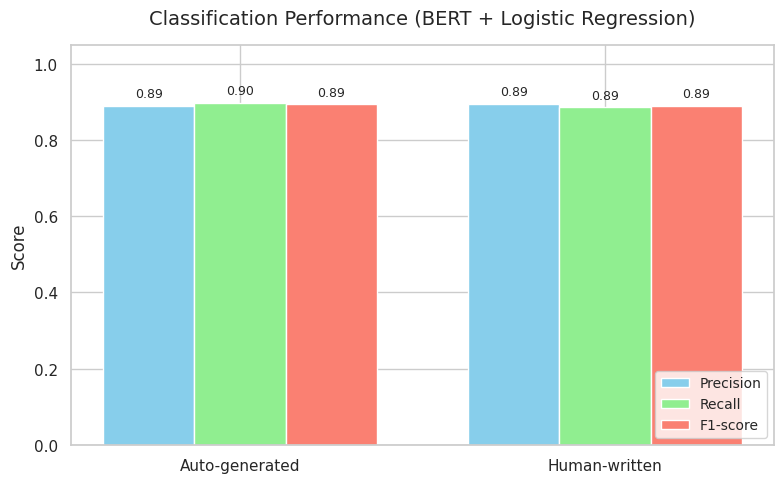

In [14]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# 📌 Get classification report as dict
report = classification_report(y_val, y_pred, output_dict=True, target_names=["Auto-generated", "Human-written"])

labels = ["Auto-generated", "Human-written"]
metrics = ["Precision", "Recall", "F1-score"]

# 각 metric별로 값 추출
precision = [report[label]["precision"] for label in labels]
recall    = [report[label]["recall"]    for label in labels]
f1        = [report[label]["f1-score"]  for label in labels]

# 그래프 데이터 구성
data = np.array([precision, recall, f1])
x = np.arange(len(labels))  # [0, 1]
width = 0.25

# 그래프 스타일
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(8, 5))

# 막대그래프 3개
rects1 = ax.bar(x - width, data[0], width, label='Precision', color='skyblue')
rects2 = ax.bar(x,         data[1], width, label='Recall',    color='lightgreen')
rects3 = ax.bar(x + width, data[2], width, label='F1-score',  color='salmon')

# 축/범례 설정
ax.set_title("Classification Performance (BERT + Logistic Regression)", fontsize=14, pad=15)
ax.set_ylabel("Score", fontsize=12)
ax.set_ylim(0, 1.05)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=11)
ax.legend(loc="lower right", fontsize=10)

# 바 위에 수치 표시
for rect_group in [rects1, rects2, rects3]:
    for rect in rect_group:
        height = rect.get_height()
        ax.annotate(f"{height:.2f}",
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 4),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=9)

plt.tight_layout()
plt.show()


## 2-1 SVM

In [1]:
import os
import json
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


In [2]:
# Cell 1: processPattern 분포 확인
import os
import json
from collections import Counter

base_dirs = [
    "/home/linux1126/146.낚시성 기사 탐지 데이터/01-1.정식개방데이터/Training",
    "/home/linux1126/146.낚시성 기사 탐지 데이터/01-1.정식개방데이터/Validation"
]

pattern_counter = Counter()
for base_dir in base_dirs:
    for root, _, files in os.walk(base_dir):
        for file in files:
            if file.endswith('.json'):
                try:
                    with open(os.path.join(root, file), 'r', encoding='utf-8') as f:
                        j = json.load(f)
                        p = j.get('sourceDataInfo', {}).get('processPattern', '')
                        if p:
                            pattern_counter[p] += 1
                except:
                    pass

# 분포 상위 10개 패턴 출력
print("Top 10 processPatterns:")
for pat, cnt in pattern_counter.most_common(10):
    print(f"Pattern {pat}: {cnt}")

# Cell 2: 상업성 패턴 설정 (위 분포를 보고 수정)
target_patterns = ['21', '22', '23']  # 상업성 반복 기사 패턴 목록
general_patterns = ['00', '99']      # 일반 기사 패턴 목록

# Cell 3: 데이터 수집
import pandas as pd
from tqdm import tqdm

def collect_by_pattern(base_dirs, target_patterns, general_patterns, sample_per_class=5000):
    targ, gen = [], []
    for base_dir in base_dirs:
        for root, _, files in os.walk(base_dir):
            for file in tqdm(files, desc="Collecting articles"):
                if not file.endswith('.json'):
                    continue
                try:
                    with open(os.path.join(root, file), 'r', encoding='utf-8') as f:
                        j = json.load(f)
                        sdi = j.get('sourceDataInfo', {})
                        # 원본 제목 필드 사용
                        title = sdi.get('newsTitle', '').strip()
                        content = sdi.get('newsContent', '').strip()
                        pat = sdi.get('processPattern', '')
                        if not title or not content or not pat:
                            continue
                        text = title + ' ' + content
                        if pat in target_patterns and len(targ) < sample_per_class:
                            targ.append({'text': text, 'label': 1})
                        if pat in general_patterns and len(gen) < sample_per_class:
                            gen.append({'text': text, 'label': 0})
                        if len(targ) >= sample_per_class and len(gen) >= sample_per_class:
                            break
                except Exception:
                    pass
        if len(targ) >= sample_per_class and len(gen) >= sample_per_class:
            break
    df = pd.DataFrame(targ + gen)
    return df.sample(frac=1, random_state=42).reset_index(drop=True)

# Cell 4: 실행 및 결과 확인
df = collect_by_pattern(base_dirs, target_patterns, general_patterns, sample_per_class=5000)
print(df['label'].value_counts())
df.head()


Top 10 processPatterns:
Pattern 00: 654062
Pattern 99: 485624
Pattern 24: 36640
Pattern 11: 33320
Pattern 12: 26322
Pattern 23: 22130
Pattern 21: 20558
Pattern 22: 10920
Pattern 15: 9520
Pattern 14: 8382


label
0    5000
1    5000
Name: count, dtype: int64


,text,label
0,"日 \""北 탄도미사일 2발 발사…EEZ 밖에 낙하\""(종합2보) 일본의 기시 노부오...",0
1,"유시민 \""이승만 무능한 대통령, 박정희 권력의지 강한 사람\"" 유시민 노무현재단 ...",1
2,호주 해변 출몰 ‘2m 상어’…발목 깊이서 ‘버둥’[영상] 호주 시드니의 한 해변에...,1
3,"광주천, 이제 시민이 가꾼다 무등산과 더불어 광주의 상징이자 광주의 젖줄인 광주천을...",1
4,‘조선의 독도 영유’ 증명하는 사료 ‘울릉도사적’ 추가 발견 조선 후기 조선의 행정...,1


In [3]:
df['label'].value_counts()
df.tail()

,text,label
9995,"정부, 소부장 통계 만든다…소재부품＋'장비'로 확대 개편 정부가 소재·부품·장비(소...",0
9996,"\""코로나 방지 추적 앱·열 카메라 사생활 침해 문제\"" 전문가들이 코로나19를 퇴...",0
9997,다음 '연예뉴스' 댓글 사라졌다 포털사이트 다음의 연예뉴스 댓글 서비스가 폐지됐다....,0
9998,"SKT \""철도 통신 속도, 지금보다 10배 높인다\"" SK텔레콤은 11일 한국철도...",1
9999,[단독] '선거 개입' 강신명 前경찰청장 외국계 로펌서 고문 활동 논란 한덕수 국무...,0


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['label'], test_size=0.2, stratify=df['label'], random_state=42
)

vectorizer = TfidfVectorizer(
    max_features=10000, ngram_range=(1,3), min_df=5, sublinear_tf=True
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print('Train shape:', X_train_tfidf.shape)
print('Test shape:', X_test_tfidf.shape)


Train shape: (8000, 10000)
Test shape: (2000, 10000)


In [5]:
svm_clf = SVC(kernel='linear', class_weight='balanced')
svm_clf.fit(X_train_tfidf, y_train)
y_pred = svm_clf.predict(X_test_tfidf)

print(classification_report(
    y_test, y_pred, target_names=['General','Commercial'], digits=4
))


              precision    recall  f1-score   support

     General     0.6042    0.6090    0.6066      1000
  Commercial     0.6058    0.6010    0.6034      1000

    accuracy                         0.6050      2000
   macro avg     0.6050    0.6050    0.6050      2000
weighted avg     0.6050    0.6050    0.6050      2000



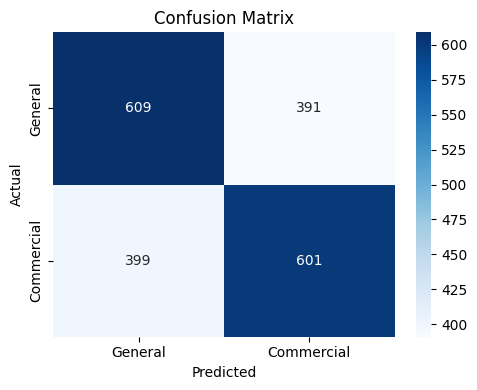

In [10]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['General','Commercial'],
            yticklabels=['General','Commercial'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


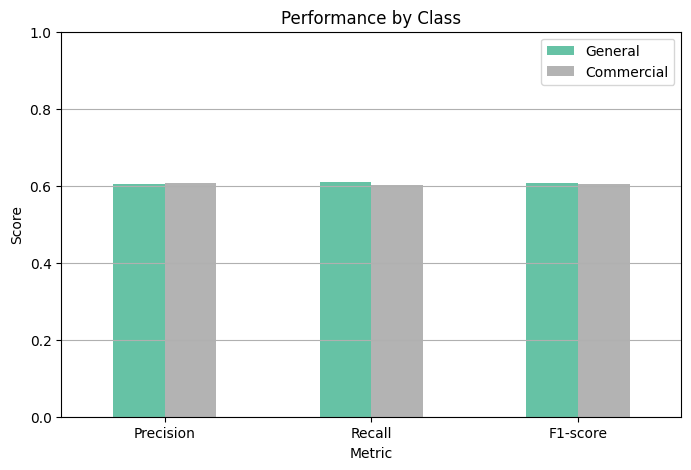

In [6]:
from sklearn.metrics import precision_recall_fscore_support

# 성능 지표 계산
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, labels=[0, 1])

# 시각화용 데이터 준비
metrics_df = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'F1-score'],
    'General': [precision[0], recall[0], f1[0]],
    'Commercial': [precision[1], recall[1], f1[1]]
})

# 막대그래프
metrics_df.set_index('Metric').plot(kind='bar', figsize=(8, 5), ylim=(0, 1), colormap='Set2')
plt.title("Performance by Class")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()


In [13]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,3), max_features=20000, min_df=3, max_df=0.9, sublinear_tf=True)),
    ('svm', SVC(class_weight='balanced'))
])

param_grid = {
    'tfidf__ngram_range': [(1,2), (1,3)],
    'tfidf__max_features': [5000, 10000],
    'svm__C': [0.1, 1, 10],
    'svm__kernel': ['linear', 'rbf'],
}

grid = GridSearchCV(pipeline, param_grid, cv=3, scoring='f1_macro', n_jobs=-1, verbose=2)
grid.fit(X_train, y_train)

print('Best Params:', grid.best_params_)
y_pred_grid = grid.predict(X_test)

print(classification_report(
    y_test, y_pred_grid, target_names=['General','Commercial'], digits=4
))


Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] END svm__C=1, svm__kernel=linear, tfidf__max_features=5000, tfidf__ngram_range=(1, 2); total time= 1.3min
[CV] END svm__C=1, svm__kernel=linear, tfidf__max_features=5000, tfidf__ngram_range=(1, 2); total time= 1.4min
[CV] END svm__C=1, svm__kernel=linear, tfidf__max_features=5000, tfidf__ngram_range=(1, 2); total time= 1.4min
[CV] END svm__C=0.1, svm__kernel=linear, tfidf__max_features=5000, tfidf__ngram_range=(1, 2); total time= 1.4min
[CV] END svm__C=0.1, svm__kernel=linear, tfidf__max_features=5000, tfidf__ngram_range=(1, 2); total time= 1.4min
[CV] END svm__C=0.1, svm__kernel=rbf, tfidf__max_features=5000, tfidf__ngram_range=(1, 2); total time= 1.5min
[CV] END svm__C=0.1, svm__kernel=rbf, tfidf__max_features=5000, tfidf__ngram_range=(1, 2); total time= 1.5min
[CV] END svm__C=0.1, svm__kernel=linear, tfidf__max_features=5000, tfidf__ngram_range=(1, 2); total time= 1.5min
[CV] END svm__C=0.1, svm__kernel=rbf, tfidf__ma

## 2-2 RandomForest

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline


In [ ]:
# 텍스트와 레이블이 있는 DataFrame (예: df['text'], df['label']) 필요
# 라벨이 'general', 'commercial' 로 되어 있다고 가정
df['label'] = df['label'].map({'general': 0, 'commercial': 1})

Series([], Name: count, dtype: int64)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['label'], test_size=0.2, stratify=df['label'], random_state=42
)


In [23]:
rf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=10000, ngram_range=(1, 2))),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42))
])

rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)

print("📊 Random Forest Results")
print(classification_report(y_test, y_pred_rf, target_names=["General", "Commercial"]))


📊 Random Forest Results
              precision    recall  f1-score   support

     General       0.60      0.65      0.62      1000
  Commercial       0.61      0.56      0.59      1000

    accuracy                           0.60      2000
   macro avg       0.61      0.60      0.60      2000
weighted avg       0.61      0.60      0.60      2000



In [ ]:
xgb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=10000, ngram_range=(1, 2))),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

xgb_pipeline.fit(X_train, y_train)
y_pred_xgb = xgb_pipeline.predict(X_test)

print("📊 XGBoost Results")
print(classification_report(y_test, y_pred_xgb, target_names=["General", "Commercial"]))
## 

/home/linux1126/hypo1/DEV/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:56:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


📊 XGBoost Results
              precision    recall  f1-score   support

     General       0.59      0.57      0.58      1000
  Commercial       0.58      0.60      0.59      1000

    accuracy                           0.58      2000
   macro avg       0.58      0.58      0.58      2000
weighted avg       0.58      0.58      0.58      2000



## 2-3 Bert-SVM

In [26]:
from transformers import AutoTokenizer, AutoModel
import torch
from tqdm import tqdm
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report


In [28]:
df['label'] = df['label'].map({'general': 0, 'commercial': 1})
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['label'], test_size=0.2, stratify=df['label'], random_state=42
)


ValueError: Input y contains NaN.